### Adding Memory In Agentic Graph...

In [1]:
from typing_extensions import TypedDict
from typing import Annotated

from langgraph.graph.message import add_messages      ## Reducer

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [4]:
from langchain_tavily import TavilySearch

tavily = TavilySearch(max_results=2)

In [5]:
tavily.invoke("What is the Importance of Reinforcement Learning?")

{'query': 'What is the Importance of Reinforcement Learning?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://birchwoodu.org/reinforcement-learning-advantages-and-disadvantages/',
   'title': 'What are the Reinforcement Learning Advantages and Disadvantages',
   'content': 'Welcome to the realm of reinforcement learning (RL). Reinforcement learning is a type of machine learning where an agent learns to make decisions by taking actions in an environment to maximize cumulative rewards. Instead, RL systems learn directly from their experiences, making them particularly valuable in fields where data is scarce or challenging to label. For example, in robotics, an RL agent can learn to grasp objects more effectively through trial and error, adapting its approach based on previous failures. For instance, a self-driving car must adapt to varying traffic patterns and weather conditions, which can be effectively managed through reinforcement learning 

In [6]:
# My Custom Tool -> It's Not any Thing Special, Just a Python Function

def multiply(a:int, b:int) -> int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a * b

In [7]:
tools = [tavily, multiply]

In [8]:
from langchain_groq import ChatGroq

llm_with_tools = ChatGroq(model="llama-3.3-70b-versatile").bind_tools(tools=tools)

In [9]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001C7D116BF80>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001C7D1C03020>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description':

In [10]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [11]:
memory = MemorySaver()

In [12]:
## Node Defination
def tool_calling_llm(state: State):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

In [13]:
## Initialize The State Graph
graph_builder = StateGraph(State)

In [14]:
## Add The Required Nodes
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [15]:
## Add The Needed Edges
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
graph_builder.add_edge("tools", "tool_calling_llm")

In [16]:
## Let's Compile The Graph
graph = graph_builder.compile(checkpointer=memory)

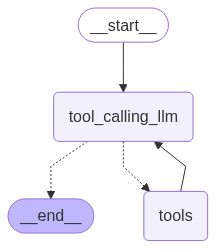

In [17]:
## Display The Graph
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
config = {
    "configurable": {"thread_id": "1"}
}

In [20]:
graph.invoke({
    "messages": "What is the latest news about Reinforcement Learning?"
}, config=config)

{'messages': [HumanMessage(content='What is the latest news about Reinforcement Learning?', additional_kwargs={}, response_metadata={}, id='f03df6d3-d6a9-4a75-a907-210080ffd810'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4e1zc4f8z', 'function': {'arguments': '{"query":"latest news Reinforcement Learning","time_range":"day","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 1859, 'total_tokens': 1892, 'completion_time': 0.090622377, 'prompt_time': 0.139998411, 'queue_time': 0.08623149300000002, 'total_time': 0.230620788}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f78a444d-08fe-4c73-9a80-186bf38b455a-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'latest news Reinforcement Learning', 'time_range': 'day', 'topic': 'general'}, 'id': '

In [22]:
response = graph.invoke({
    "messages": "What is the most powerful research news in Reinforcement Learning?"
}, config=config)

response["messages"][-1].content

'The most powerful research news in Reinforcement Learning includes the development of Qwen2-Math, a new era for AI maths whizzes, and the deployment of ERNIE Bot generative AI to the public. Additionally, there have been breakthroughs in analog AI chips for efficient deep learning, next-gen GPU acceleration for AI, and new AI training techniques to overcome current challenges. Furthermore, there have been advancements in GenAI through Reinforcement Learning from Human Feedback (RLHF) and the development of reasoning LLMs. The Turing Award was also awarded to two research scientists for their work on reinforcement learning.'

In [23]:
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest news about Reinforcement Learning?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (4e1zc4f8z)
 Call ID: 4e1zc4f8z
  Args:
    query: latest news Reinforcement Learning
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news Reinforcement Learning", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.openpr.com/news/4127549/future-of-the-reinforcement-learning-market-trends", "title": "Future of the Reinforcement Learning Market: Trends, - openPR.com", "content": "Moving from $10.49 billion in 2024, the market is slated to reach $13.52 billion in 2025, witnessing a compound annual growth rate (CAGR) of 28.9%.", "score": 0.55362654, "raw_content": null}, {"url": "https://news.ycombi

In [24]:
response = graph.invoke({
    "messages": "Multiply 51 and 6"
}, config=config)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest news about Reinforcement Learning?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (4e1zc4f8z)
 Call ID: 4e1zc4f8z
  Args:
    query: latest news Reinforcement Learning
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news Reinforcement Learning", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.openpr.com/news/4127549/future-of-the-reinforcement-learning-market-trends", "title": "Future of the Reinforcement Learning Market: Trends, - openPR.com", "content": "Moving from $10.49 billion in 2024, the market is slated to reach $13.52 billion in 2025, witnessing a compound annual growth rate (CAGR) of 28.9%.", "score": 0.55362654, "raw_content": null}, {"url": "https://news.ycombi

In [25]:
response = graph.invoke({
    "messages": "What is the latest news about Reinforcement Learning and then Multiply 51 by 6??"
}, config=config)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest news about Reinforcement Learning?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (4e1zc4f8z)
 Call ID: 4e1zc4f8z
  Args:
    query: latest news Reinforcement Learning
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news Reinforcement Learning", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.openpr.com/news/4127549/future-of-the-reinforcement-learning-market-trends", "title": "Future of the Reinforcement Learning Market: Trends, - openPR.com", "content": "Moving from $10.49 billion in 2024, the market is slated to reach $13.52 billion in 2025, witnessing a compound annual growth rate (CAGR) of 28.9%.", "score": 0.55362654, "raw_content": null}, {"url": "https://news.ycombi

In [26]:
response = graph.invoke({
    "messages": "Welcome, My Name is Mohamed?"
}, config=config)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest news about Reinforcement Learning?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (4e1zc4f8z)
 Call ID: 4e1zc4f8z
  Args:
    query: latest news Reinforcement Learning
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news Reinforcement Learning", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.openpr.com/news/4127549/future-of-the-reinforcement-learning-market-trends", "title": "Future of the Reinforcement Learning Market: Trends, - openPR.com", "content": "Moving from $10.49 billion in 2024, the market is slated to reach $13.52 billion in 2025, witnessing a compound annual growth rate (CAGR) of 28.9%.", "score": 0.55362654, "raw_content": null}, {"url": "https://news.ycombi

In [27]:
response = graph.invoke({
    "messages": "What is my name?"
}, config=config)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest news about Reinforcement Learning?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (4e1zc4f8z)
 Call ID: 4e1zc4f8z
  Args:
    query: latest news Reinforcement Learning
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news Reinforcement Learning", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.openpr.com/news/4127549/future-of-the-reinforcement-learning-market-trends", "title": "Future of the Reinforcement Learning Market: Trends, - openPR.com", "content": "Moving from $10.49 billion in 2024, the market is slated to reach $13.52 billion in 2025, witnessing a compound annual growth rate (CAGR) of 28.9%.", "score": 0.55362654, "raw_content": null}, {"url": "https://news.ycombi

You Observed That All Chat Were Saved ??